# Attitude Sequence

This example is based on the attitude tutorial in the orekit library and webpage https://www.orekit.org/static/tutorial/attitude.html by Luc Maisonobe written in Java. This version of the example is based on ipython notebook, using a python-wrapped version of the orekit library, as a demonstration of the python capabilities and as a tutorial. Conversion made by Petrus Hyvönen, SSC, 2014.

This example uses AttitudesSequence that enables easy switching between attitude laws on event occurrences when propagating some SpacecraftState.

In [1]:
%pylab inline
figsize(12,12)

Populating the interactive namespace from numpy and matplotlib


In [2]:
#initialize orekit and JVM
import orekit
orekit.initVM()

In [8]:
# setup the orekit data loading, the file orekit-data.zip shall be in same directory as notebook.
from orekit.pyhelpers import setup_orekit_curdir
setup_orekit_curdir()

In [9]:
from org.hipparchus.geometry.euclidean.threed import RotationOrder;
from org.hipparchus.geometry.euclidean.threed import Vector3D;

In [10]:
from org.orekit.attitudes import AttitudeProvider;
from org.orekit.attitudes import AttitudesSequence;
from org.orekit.attitudes import LofOffset;
from org.orekit.bodies import CelestialBodyFactory;
from org.orekit.errors import OrekitException;
from org.orekit.errors import PropagationException;
from org.orekit.frames import FramesFactory;
from org.orekit.frames import LOFType;
from org.orekit.orbits import KeplerianOrbit;
from org.orekit.orbits import Orbit;
from org.orekit.propagation import Propagator;
from org.orekit.propagation import SpacecraftState;
from org.orekit.propagation.analytical import EcksteinHechlerPropagator;
from org.orekit.propagation.events import EclipseDetector;
from org.orekit.propagation.events import EventDetector;
from org.orekit.propagation.events.handlers import EventHandler;
from org.orekit.propagation.sampling import OrekitFixedStepHandler;
from org.orekit.time import AbsoluteDate;
from org.orekit.time import TimeScalesFactory;
from org.orekit.utils import Constants;
from org.orekit.utils import PVCoordinates;
from org.orekit.utils import PVCoordinatesProvider;

In [11]:
from org.orekit.python import PythonEventHandler, PythonOrekitFixedStepHandler

Let's set up an initial state as:

- a date in UTC time scale
- an orbit defined by the position and the velocity of the spacecraft in the EME2000 inertial frame and an associated central attraction coefficient chosen among many physical constants available in Orekit.

The initial orbit is here defined as a KeplerianOrbit.

In [12]:
initialDate =  AbsoluteDate(2004, 01, 01, 23, 30, 00.000, TimeScalesFactory.getUTC())
position  = Vector3D(-6142438.668, 3492467.560, -25767.25680);
velocity  = Vector3D(505.8479685, 942.7809215, 7435.922231);
initialOrbit =  KeplerianOrbit(PVCoordinates(position, velocity),
                                                          FramesFactory.getEME2000(), initialDate,
                                                          Constants.EIGEN5C_EARTH_MU);

In [13]:
print initialOrbit

keplerian parameters: {a: 7069220.386682823; e: 4.777356060557311E-4; i: 98.18525099174988; pa: 13.741061002484528; raan: 150.34825333049; v: -13.952151446378437;}


More details on the orbit representation can be found in the orbits section of the library architecture documentation. Note that in the python wrapping of orekit the format of numbers is important, such that floats needs to be specified with a decimal point such as in the AbsoluteDate above where seconds are a float.

Let's define a couple of AttitudeLaw for our satellite, one for daytime and one for nighttime, built upon Local Orbital Frame (Lof) Offset laws. VVLH is a coodrinate system based on Vehicle Velocity, Local Horizontal frame (Z axis aligned with nadir vector, X-Y is in horizontal plane, where the X-axis is along the velocity vector). The offset is defined in Cardan angles (RotationOrder.XYZ).

In [14]:
dayObservationLaw =  LofOffset(initialOrbit.getFrame(), 
                               LOFType.VVLH,
                               RotationOrder.XYZ, 
                               math.radians(20), math.radians(40), 0.0)

In night we want the pointing to be in LOF aligned. 

In [15]:
nightRestingLaw   = LofOffset(initialOrbit.getFrame(), LOFType.VVLH)

Let's also define some EventDetectors for the switching. For this tutorial's requirements, two specialized event detectors are built 
upon an EclipseDetector:

one, dayNightEvent, to detect the day to night transition,
another, nightDayEvent, to detect the night to day transition.
This is done by overriding the eventOccurred method of the standard EclipseDetector. To override methods in a java class in Python,
a special wrapped version of the class is used, called PythonElevationDetector.

In [16]:
class myNightEclipseDetector(PythonEventHandler):
    
    def eventOccurred(self, s, detector, increasing):
        if not increasing:
            print s.getDate()," : event occurred, entering eclipse => switching to night law"
        return EventHandler.Action.CONTINUE
    
    def resetState(self, detector, oldState):
        return oldState;

In [17]:
class myDayEclipseDetector(PythonEventHandler):
    
    def eventOccurred(self, s, detector, increasing):
        if increasing:
            print s.getDate()," : event occurred, exiting eclipse => switching to day law"
        return EventHandler.Action.CONTINUE
    
    def resetState(self, detector, oldState):
        return oldState

For the eclipse calculation we want to use the Sun and the Earth.

In [18]:
sun = CelestialBodyFactory.getSun()
earth = CelestialBodyFactory.getEarth()

Create the actual detectors with the the handlers specified above.

In [19]:
dayNightEvent = EclipseDetector(sun, 696000000., earth, Constants.WGS84_EARTH_EQUATORIAL_RADIUS)
dayNightEvent = dayNightEvent.withHandler(myNightEclipseDetector().of_(EclipseDetector))

In [20]:
nightDayEvent = EclipseDetector(sun, 696000000., earth, Constants.WGS84_EARTH_EQUATORIAL_RADIUS)
nightDayEvent = nightDayEvent.withHandler(myDayEclipseDetector().of_(EclipseDetector))

More details on event detectors can be found in the propagation section of the library architecture documentation.

An AttitudesSequence is then defined, for the sake of this tutorial, by adding two switching conditions acting as a simple loop:

- the first one enables the transition from dayObservationLaw to nightRestingLaw when a decreasing dayNightEvent occurs,
- the second one enables the transition from nightRestingLaw to dayObservationLaw when an increasing nightDayEvent occurs.


In [21]:
attitudesSequence = AttitudesSequence()
attitudesSequence.addSwitchingCondition(dayObservationLaw, dayNightEvent, False, True, nightRestingLaw)
attitudesSequence.addSwitchingCondition(nightRestingLaw,   nightDayEvent, True, False, dayObservationLaw)

InvalidArgsError: (<type 'AttitudesSequence'>, 'addSwitchingCondition', (<LofOffset: org.orekit.attitudes.LofOffset@17c386de>, <EclipseDetector: org.orekit.propagation.events.EclipseDetector@45dd4eda>, False, True, <LofOffset: org.orekit.attitudes.LofOffset@5af97850>))

An AttitudesSequence needs at least one switching condition to be meaningful, but there is no upper limit.

An active AttitudeLaw may have several switch events and next law settings, leading to different activation patterns depending on which event is triggered first.

So, don't forget to set the current active law according to the current state:

In [17]:
if (dayNightEvent.g(SpacecraftState(initialOrbit)) >= 0):
    # initial position is in daytime
    attitudesSequence.resetActiveProvider(dayObservationLaw);
else:
    # initial position is in nighttime
    attitudesSequence.resetActiveProvider(nightRestingLaw);

Now, let's choose some propagator to compute the spacecraft motion. We will use an EcksteinHechlerPropagator based on the analytical Eckstein-Hechler model. The propagator is built upon the initialOrbit, the attitudeSequence and physical constants for the gravity field potential.

In [18]:
propagator = EcksteinHechlerPropagator(initialOrbit, attitudesSequence,
                                                            Constants.EIGEN5C_EARTH_EQUATORIAL_RADIUS,
                                                            Constants.EIGEN5C_EARTH_MU, Constants.EIGEN5C_EARTH_C20,
                                                            Constants.EIGEN5C_EARTH_C30, Constants.EIGEN5C_EARTH_C40,
                                                            Constants.EIGEN5C_EARTH_C50, Constants.EIGEN5C_EARTH_C60)

The attitudeSequence must register all the switching events before propagation.

In [19]:
# Register the switching events to the propagator
attitudesSequence.registerSwitchEvents(propagator)

The propagator operating mode is set to master mode with fixed step. The implementation of the interface OrekitFixedStepHandler aims to define the handleStep method called within the loop. For the purpose of this tutorial, the handleStep method will print at the current date two angles, the first one indicates if the spacecraft is eclipsed while the second informs about the current attitude law.

In [20]:
class mystephandler(PythonOrekitFixedStepHandler):
    
    eclipseAngles = []
    pointingOffsets = []
    dates = []
    
    def init(self,s0, t):
        pass
        
    def handleStep(self,currentState, isLast):
        # the Earth position in spacecraft frame should be along spacecraft Z axis
        # during nigthtime and away from it during daytime due to roll and pitch offsets
        earth = currentState.toTransform().transformPosition(Vector3D.ZERO)
        pointingOffset = Vector3D.angle(earth, Vector3D.PLUS_K)

        # the g function is the eclipse indicator, its an angle between Sun and Earth limb,
        # positive when Sun is outside of Earth limb, negative when Sun is hidden by Earth limb
        eclipseAngle = dayNightEvent.g(currentState)
        print "%s    %6.3f    %6.1f" % (currentState.getDate(), eclipseAngle, math.degrees(pointingOffset))
        
        self.eclipseAngles.append(eclipseAngle)
        self.pointingOffsets.append(math.degrees(pointingOffset))
        self.dates.append(currentState.getDate())

In [21]:
handler = mystephandler()
propagator.setMasterMode(180.0, handler)

More details on propagation modes can be found in the propagation section of the library architecture documentation.

Finally, the propagator is just asked to propagate for a given duration.

In [22]:
# Propagate from the initial date for the fixed duration
finalState = propagator.propagate(initialDate.shiftedBy(12600.))

2004-01-01T23:30:00.000    -0.203       0.0
2004-01-01T23:33:00.000    -0.311       0.0
2004-01-01T23:36:00.000    -0.392       0.0
2004-01-01T23:39:00.000    -0.437       0.0
2004-01-01T23:42:00.000    -0.439       0.0
2004-01-01T23:45:00.000    -0.397       0.0
2004-01-01T23:48:00.000    -0.318       0.0
2004-01-01T23:51:00.000    -0.212       0.0
2004-01-01T23:55:57.968  : event occurred, exiting eclipse => switching to day law
2004-01-01T23:54:00.000    -0.088       0.0
2004-01-01T23:57:00.000     0.048      44.0
2004-01-02T00:00:00.000     0.191      44.0
2004-01-02T00:03:00.000     0.338      44.0
2004-01-02T00:06:00.000     0.487      44.0
2004-01-02T00:09:00.000     0.636      44.0
2004-01-02T00:12:00.000     0.782      44.0
2004-01-02T00:15:00.000     0.922      44.0
2004-01-02T00:18:00.000     1.052      44.0
2004-01-02T00:21:00.000     1.168      44.0
2004-01-02T00:24:00.000     1.261      44.0
2004-01-02T00:27:00.000     1.322      44.0
2004-01-02T00:30:00.000     1.342    

In [23]:
print("Propagation ended at " + finalState.getDate().toString())

Propagation ended at 2004-01-02T03:00:00.000


To plot nicely in Python, we should convert the orekit AbsoluteDate to python DateTime objects.

In [24]:
from datetime import datetime
def absolutedate_to_datetime(orekit_date):

    utc = TimeScalesFactory.getUTC()
    or_comp = orekit_date.getComponents(utc)
    or_date = or_comp.getDate()
    or_time = or_comp.getTime()
    seconds = or_time.getSecond()
    return datetime(or_date.getYear(),
             or_date.getMonth(),
             or_date.getDay(),
             or_time.getHour(),
             or_time.getMinute(),
             int(math.floor(seconds)),
             int(1000.0 * (seconds - math.floor(seconds))))

In [25]:
pydates = [absolutedate_to_datetime(t) for t in handler.dates]

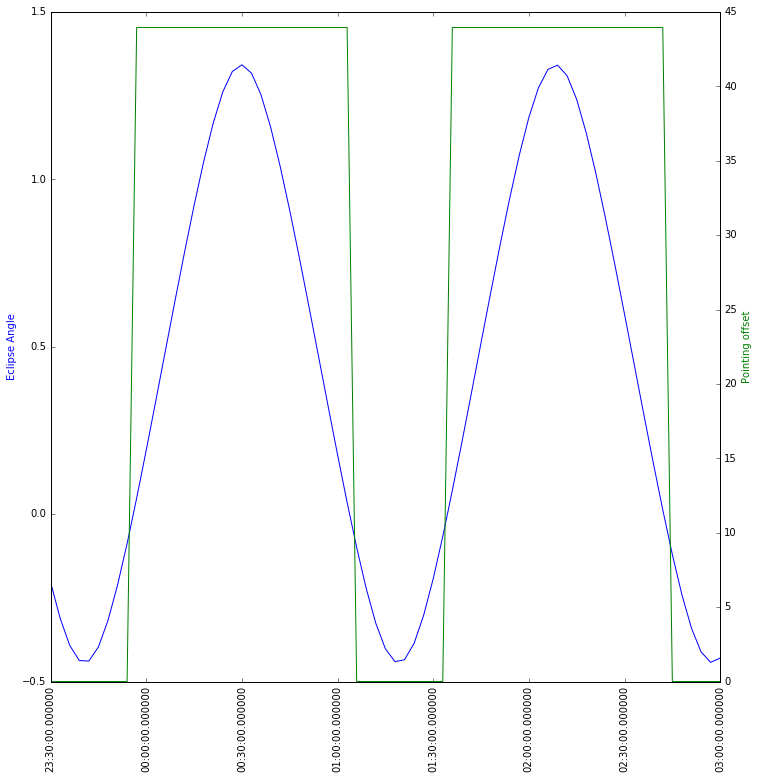

In [26]:
plt.xticks(rotation=90)
ax = plt.gca()
ax2 = ax.twinx()

ax.plot(pydates,handler.eclipseAngles, color='blue')
ax.set_ylabel('Eclipse Angle', color='blue')

ax2.plot(pydates, handler.pointingOffsets, color='green')
ax2.set_ylabel('Pointing offset', color='green');

The java code for similar example can be found in the source tree of the library, in file:

    src/tutorials/fr/cs/examples/attitude/EarthObservation.java
